In [1]:
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
path_train_data = "MNIST/mnist_training_data.mat"
path_test_data = "MNIST/mnist_test_data.mat"

In [4]:
train_data_mat = loadmat(path_train_data)
train_data = train_data_mat['training_data']

test_data_mat = loadmat(path_test_data)
test_data = test_data_mat['test_data']

In [5]:
X_train = train_data.reshape((train_data.shape[0], 28, 28, 1))
X_test = test_data.reshape((test_data.shape[0], 28, 28, 1))
X_train.shape, X_test.shape

((50000, 28, 28, 1), (10000, 28, 28, 1))

In [6]:
class Sampling(tf.keras.layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
latent_dim = 2

encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = tf.keras.layers.Reshape((7, 7, 64))(x)
x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [9]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X_train, epochs=30, batch_size=512)

Epoch 1/30
98/98 [==============================] - 12s 50ms/step - loss: 385.7368 - reconstruction_loss: 287.3152 - kl_loss: 1.8270
Epoch 2/30
98/98 [==============================] - 4s 43ms/step - loss: 208.9855 - reconstruction_loss: 203.4924 - kl_loss: 2.9493
Epoch 3/30
98/98 [==============================] - 4s 42ms/step - loss: 200.8891 - reconstruction_loss: 196.9673 - kl_loss: 3.1469
Epoch 4/30
98/98 [==============================] - 4s 41ms/step - loss: 197.6968 - reconstruction_loss: 193.9190 - kl_loss: 3.3332
Epoch 5/30
98/98 [==============================] - 4s 44ms/step - loss: 195.4776 - reconstruction_loss: 191.5211 - kl_loss: 3.4293
Epoch 6/30
98/98 [==============================] - 4s 43ms/step - loss: 193.3201 - reconstruction_loss: 189.5405 - kl_loss: 3.5265
Epoch 7/30
98/98 [==============================] - 4s 43ms/step - loss: 192.0482 - reconstruction_loss: 187.7169 - kl_loss: 3.5554
Epoch 8/30
98/98 [==============================] - 4s 42ms/step - loss: 18

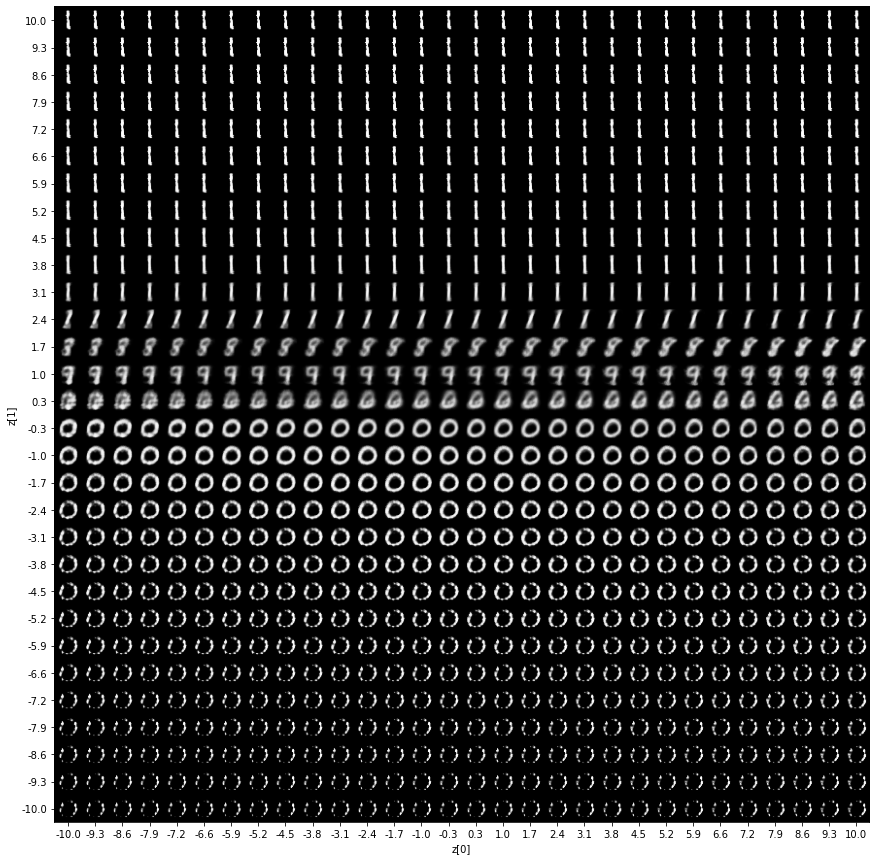

In [12]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 10.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)